In [ ]:
import torch
from transformers import CLIPImageProcessor, CLIPVisionModel
from diffusers import AutoencoderKL, DDPMScheduler
from diffusers.utils import load_image
from src.diffusers.models.referencenet.unet_2d_condition import UNet2DConditionModel
from src.diffusers.models.referencenet.referencenet_unet_2d_condition import (
    ReferenceNetModel,
)
from src.diffusers.pipelines.referencenet.pipeline_referencenet import (
    StableDiffusionReferenceNetPipeline,
)

In [ ]:
# create & load models
fams_model_id = "hkung/fams"
clip_model_id = "openai/clip-vit-large-patch14"
sd_model_id = "stabilityai/stable-diffusion-2-1"

unet = UNet2DConditionModel.from_pretrained(
    fams_model_id, subfolder="unet", use_safetensors=True
)
referencenet = ReferenceNetModel.from_pretrained(
    fams_model_id, subfolder="referencenet", use_safetensors=True
)
conditioning_referencenet = ReferenceNetModel.from_pretrained(
    fams_model_id, subfolder="conditioning_referencenet", use_safetensors=True
)
vae = AutoencoderKL.from_pretrained(sd_model_id, subfolder="vae", use_safetensors=True)
scheduler = DDPMScheduler.from_pretrained(
    sd_model_id, subfolder="scheduler", use_safetensors=True
)
feature_extractor = CLIPImageProcessor.from_pretrained(
    clip_model_id, use_safetensors=True
)
image_encoder = CLIPVisionModel.from_pretrained(clip_model_id, use_safetensors=True)

pipe = StableDiffusionReferenceNetPipeline(
    unet=unet,
    referencenet=referencenet,
    conditioning_referencenet=conditioning_referencenet,
    vae=vae,
    feature_extractor=feature_extractor,
    image_encoder=image_encoder,
    scheduler=scheduler,
)
pipe = pipe.to("cuda")

In [7]:
from PIL import Image

# A helper function to combine images horizontally
def combine_images(images):
    # Calculate the total width and the maximum height of the combined image
    total_width = sum(image.width for image in images)
    max_height = max(image.height for image in images)
    
    # Create a new blank image with the calculated dimensions
    combined_image = Image.new('RGB', (total_width, max_height))
    
    # Paste each image into the combined image
    current_x = 0
    for image in images:
        combined_image.paste(image, (current_x, 0))
        current_x += image.width
    
    return combined_image

100%|██████████| 200/200 [01:11<00:00,  2.80it/s]


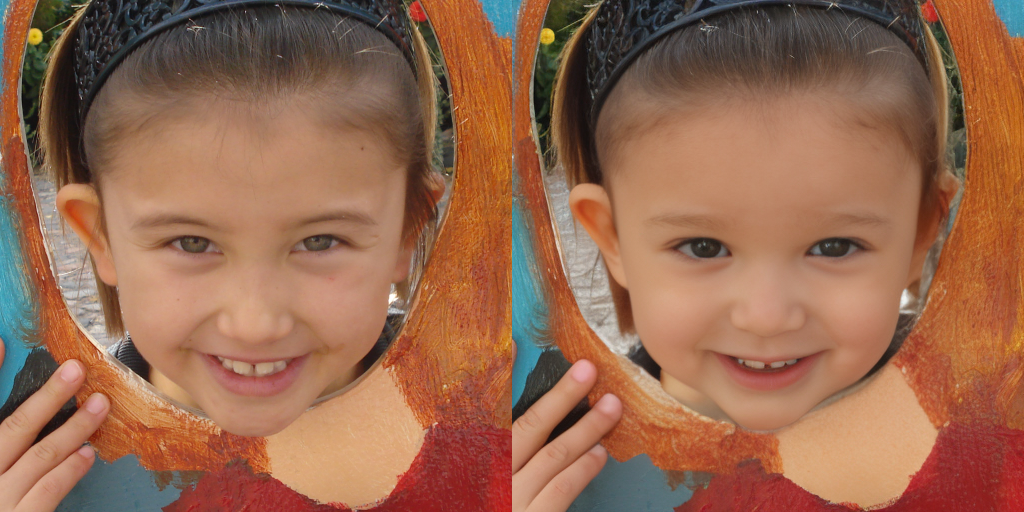

In [10]:
generator = torch.manual_seed(1)

# get an input image for anonymizationimport the library
original_image = load_image("my_dataset/14795.png")

# generate an image that anonymizes faces
anon_image = pipe(
    source_image=original_image,
    conditioning_image=original_image,
    num_inference_steps=200,
    guidance_scale=4.0,
    generator=generator,
    anonymization_degree=1.25,
).images[0]
combine_images([original_image, anon_image])

100%|██████████| 200/200 [01:12<00:00,  2.76it/s]


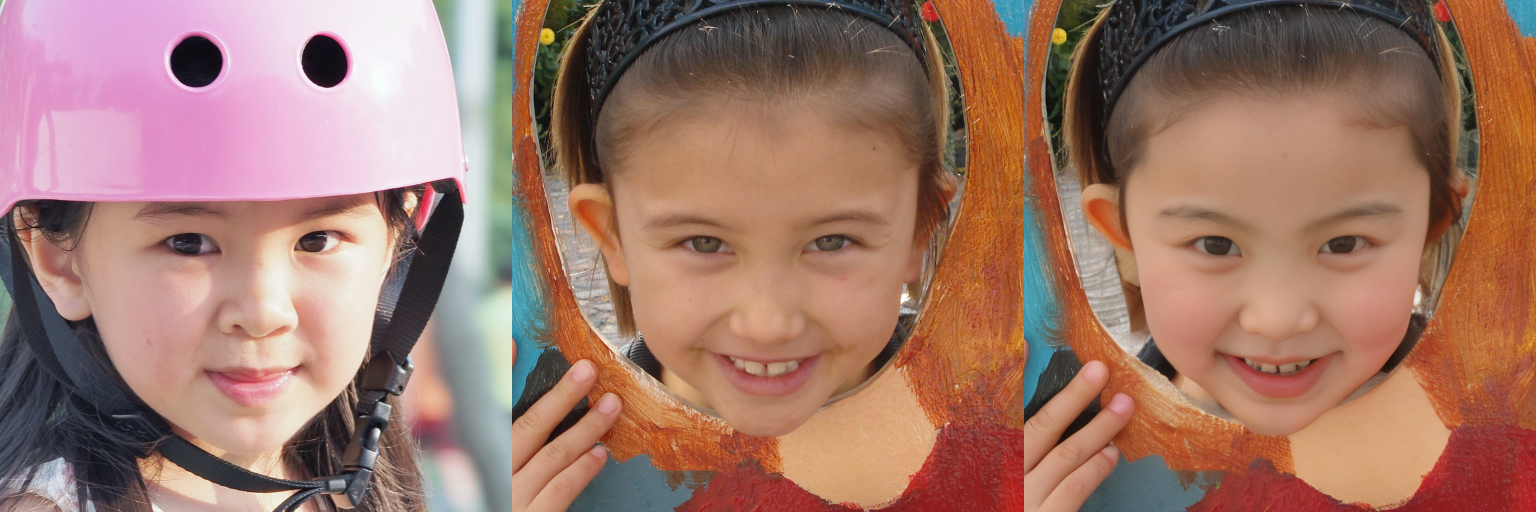

In [12]:
# get source and conditioning (driving) images for the face swap
source_image = load_image("my_dataset/00482.png")
conditioning_image = load_image("my_dataset/14795.png")

# generate an image that swaps faces
swap_image = pipe(
    source_image=source_image,
    conditioning_image=conditioning_image,
    num_inference_steps=200,
    guidance_scale=4.0,
    generator=generator,
    anonymization_degree=0.0,
).images[0]
combine_images([source_image, conditioning_image, swap_image])